# Kuku projects Justdiggit
Compare vegetation index vs. temperature.

In [1]:
import ee
import datetime
import geopandas as gpd
import pandas as pd
import numpy as np

ee.Initialize()

In [2]:
gdf = gpd.read_file('shapes/Justdiggit-Kuku.shp') # shape containing all projects in kenya
admbound = gpd.read_file('shapes/admbound.shp') # total ward, Kuku

In [3]:
def get_ImageCollection(source, name, start_date, end_date, gdf):
    # area of iterest equal to total bounds of GeoDataFrame
    from shapely.geometry import box
    aoi = ee.Geometry.Polygon(box(*gdf.geometry.total_bounds).__geo_interface__['coordinates'])

    # get the dataset
    return ee.ImageCollection(source).filterDate(start_date, end_date).filterBounds(aoi).select(name)

In [4]:
def to_dataframe(geometry, name):
    # geometry to earth engine polygon
    geometry = ee.Geometry.Polygon(geometry.__geo_interface__['coordinates'])

    def calcMean(img):
        # gets the mean NDVI for the area in this image
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=250, maxPixels=10E9)
        
        # sets the date and the mean NDVI as a property of the image
        return img.set('date', img.date().format()).set('mean', mean)

    # apply the calcMean to the image collection
    col = ic.map(calcMean)
    # make dataframe
    # reduces the images properties to a list of lists
    values = col.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)

    # type casts the result into a List
    lista = ee.List(values)

    # converts the list of lists to a Dictionaty
    means = ee.Dictionary(lista.flatten())
    
    return pd.DataFrame(means.getInfo()).T # return dataframe, index datetime, col NDVI

# Vegetation Index
The [MOD13Q1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1) V6 product provides a Vegetation Index (VI) value at a per pixel basis (250 x 250 meters). There are two primary vegetation layers. 

## NDVI
The first is the Normalized Difference Vegetation Index (NDVI) which is referred to as the continuity index to the existing National Oceanic and Atmospheric Administration-Advanced Very High Resolution Radiometer (NOAA-AVHRR) derived NDVI. 

## EVI
The second vegetation layer is the Enhanced Vegetation Index (EVI) that minimizes canopy background variations and maintains sensitivity over dense vegetation conditions. The EVI also uses the blue band to remove residual atmosphere contamination caused by smoke and sub-pixel thin cloud clouds. The MODIS NDVI and EVI products are computed from atmospherically corrected bi-directional surface reflectances that have been masked for water, clouds, heavy aerosols, and cloud shadows.

We are using __EVI__.

In [5]:
# get avg-ndvi for projcts (2000-2020)
ic = get_ImageCollection(source='MODIS/006/MOD13Q1', name='EVI', start_date=ee.Date('2000-01-01'), end_date=ee.Date('2020-10-01'), gdf=gdf)
projects_frame_evi = pd.DataFrame()

for i, row in gdf.iterrows():
    coords = row['geometry']
    df = to_dataframe(coords, name='EVI')
    df.columns = [row['name']]
    display(df.head(2))
    projects_frame_evi = pd.concat([projects_frame_evi, df], axis=1)

,Kuku bunds Plot B - start Feb 2016
2000-02-18T00:00:00,1509.205143
2000-03-05T00:00:00,1431.885423


,Kuku bunds Plot D - start Feb 2016
2000-02-18T00:00:00,1208.652544
2000-03-05T00:00:00,1115.117578


,Kuku bunds Plot A - start Feb 2019
2000-02-18T00:00:00,1164.618270
2000-03-05T00:00:00,1180.658465


,Enkii Bund Plot - start Oct 2019
2000-02-18T00:00:00,1424.146684
2000-03-05T00:00:00,1443.483389


,Moilo grass seed bank
2000-02-18T00:00:00,1174.327014
2000-03-05T00:00:00,1088.549763


,Langata Grass seed bank (funded by GEF not Justdiggit)
2000-02-18T00:00:00,1195.637755
2000-03-05T00:00:00,1154.076531


,Enkii GSB
2000-02-18T00:00:00,1539.214286
2000-03-05T00:00:00,1356.149351


In [6]:
# get avg-ndvi for ward Kuku
ic = get_ImageCollection(source='MODIS/006/MOD13Q1', name='EVI', start_date=ee.Date('2000-01-01'), end_date=ee.Date('2020-10-01'), gdf=admbound)
ref_frame_evi = to_dataframe(admbound.iloc[0]['geometry'], name='EVI')
ref_frame_evi.columns = ['total Kuku']

In [7]:
total_frame_evi = pd.concat([projects_frame_evi, ref_frame_evi], axis=1)
total_frame_evi.index = pd.to_datetime(total_frame_evi.index)
total_frame_evi.head(2)

,Kuku bunds Plot B - start Feb 2016,Kuku bunds Plot D - start Feb 2016,Kuku bunds Plot A - start Feb 2019,Enkii Bund Plot - start Oct 2019,Moilo grass seed bank,Langata Grass seed bank (funded by GEF not Justdiggit),Enkii GSB,total Kuku
2000-02-18,1509.205143,1208.652544,1164.618270,1424.146684,1174.327014,1195.637755,1539.214286,1715.544613
2000-03-05,1431.885423,1115.117578,1180.658465,1443.483389,1088.549763,1154.076531,1356.149351,1704.527952


In [8]:
plot_frame = total_frame_evi['2010':].resample('y').mean().unstack().reset_index()
plot_frame.columns = ['area', 'date', 'values']
plot_frame['date'] = plot_frame['date'].dt.year
plot_frame.head(2)

,area,date,values
0,Kuku bunds Plot B - start Feb 2016,2010,1537.575986
1,Kuku bunds Plot B - start Feb 2016,2011,1466.196626


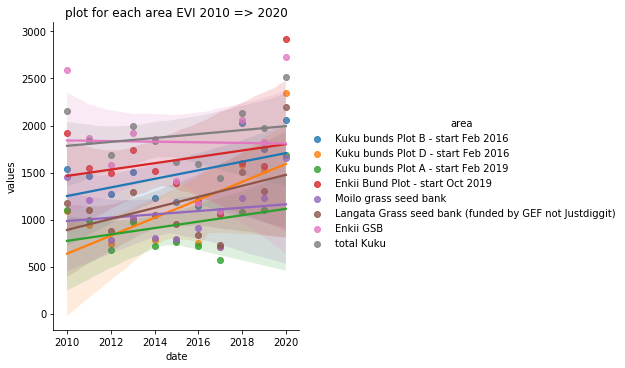

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lmplot(x='date', y='values', data=plot_frame, hue='area', truncate=True)
plt.title('plot for each area EVI 2010 => 2020');

# Surface temperature
The [MOD11A2](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A2) V6 product provides an average 8-day land surface temperature (LST) in a 1200 x 1200 kilometer grid. Each pixel (1 x 1 km) value in MOD11A2 is a simple average of all the corresponding MOD11A1 LST pixels collected within that 8 day period. The 8 day compositing period was chosen because twice that period is the exact ground track repeat period of the Terra and Aqua platforms. In this product, along with both the day- and night-time surface temperature bands and their quality indicator (QC) layers, are also MODIS bands 31 and 32 and eight observation layers.

In [10]:
# get avg-surf. temp. for projcts (2000-2020)
ic = get_ImageCollection(source='MODIS/006/MOD11A2', name='LST_Day_1km', start_date=ee.Date('2000-01-01'), end_date=ee.Date('2020-10-01'), gdf=gdf)
projects_frame_stemp = pd.DataFrame()

for i, row in gdf.iterrows():
    coords = row['geometry']
    df = to_dataframe(coords, name='LST_Day_1km')
    df.columns = [row['name']]
    display(df.head(2))
    projects_frame_stemp = pd.concat([projects_frame_stemp, df], axis=1)

,Kuku bunds Plot B - start Feb 2016
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15747.7


,Kuku bunds Plot D - start Feb 2016
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15827.9


,Kuku bunds Plot A - start Feb 2019
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15912


,Enkii Bund Plot - start Oct 2019
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15886.7


,Moilo grass seed bank
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15800


,Langata Grass seed bank (funded by GEF not Justdiggit)
2000-02-18T00:00:00,None
2000-02-26T00:00:00,16025.8


,Enkii GSB
2000-02-18T00:00:00,None
2000-02-26T00:00:00,15980


In [11]:
ic = get_ImageCollection(source='MODIS/006/MOD11A2', name='LST_Day_1km', start_date=ee.Date('2000-01-01'), end_date=ee.Date('2020-10-01'), gdf=gdf)
ref_frame_stemp = to_dataframe(admbound.iloc[0]['geometry'], name='EVI')
ref_frame_stemp.columns = ['total Kuku']

In [20]:
total_frame_stemp = pd.concat([projects_frame_stemp, ref_frame_stemp], axis=1)
total_frame_stemp.index = pd.to_datetime(total_frame_stemp.index)
total_frame_stemp = total_frame_stemp.dropna().astype('float')
total_frame_stemp.head(2)

,Kuku bunds Plot B - start Feb 2016,Kuku bunds Plot D - start Feb 2016,Kuku bunds Plot A - start Feb 2019,Enkii Bund Plot - start Oct 2019,Moilo grass seed bank,Langata Grass seed bank (funded by GEF not Justdiggit),Enkii GSB,total Kuku
2000-02-26,15747.68841,15827.922980,15912.046285,15886.676859,15800.0,16025.836735,15980.0,15812.885728
2000-03-05,15741.08357,15803.863916,15848.968819,15799.335096,15796.0,16070.857143,15940.0,15754.652419


In [21]:
plot_frame = total_frame_stemp['2010':].resample('y').mean().unstack().reset_index()
plot_frame.columns = ['area', 'date', 'values']
plot_frame['date'] = plot_frame['date'].dt.year
plot_frame.head(2)

,area,date,values
0,Kuku bunds Plot B - start Feb 2016,2010,15606.373339
1,Kuku bunds Plot B - start Feb 2016,2011,15591.142934


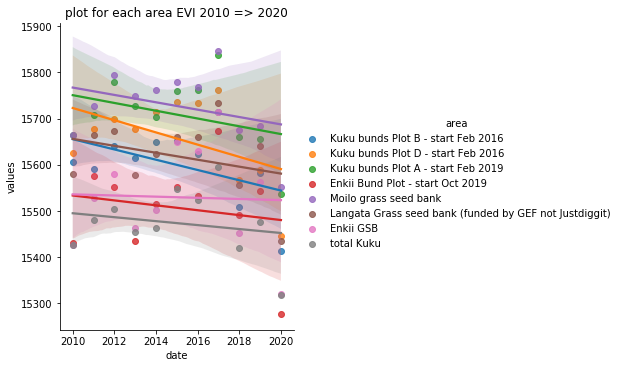

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lmplot(x='date', y='values', data=plot_frame, hue='area', truncate=True)
plt.title('plot for each area EVI 2010 => 2020');

In [24]:
# one frame to rule them all
pd.concat([total_frame_evi, total_frame_stemp], axis=1, keys=['evi', 'stemp']).to_hdf('evistemp.hdf', key='key')